In [1]:
import numpy 
import os
import ast
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

#from wquantiles import quantile
from openfisca_survey_manager.utils import asof

#from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
#from openfisca_france_indirect_taxation.surveys import SurveyScenario
#from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy
#from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile

from openfisca_france_indirect_taxation.examples.utils_example import df_weighted_average_grouped
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Reform_carbon_tax import carbon_tax_rv
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities)
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Graph_utils import (
    graph_CO2_emissions,
    graph_delta_CO2,
    graph_share_co2_emissions,
    graph_share_emissions_reduction,
    graph_ratio_emissions_reduction,
    graph_winners_losers,
    graph_net_transfers,
    graph_effort_rate,
    quantiles_for_boxplot,
    boxplot_effort_rate,
    boxplot_net_transfers
    )

In [2]:
data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
output_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Output"
elasticite = True
replique_gouv = True
sns.set_style("whitegrid")

In [3]:
df_elasticities = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
elasticites_douenne = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [30]:
def collapse_sum(dataframe, groupe, var):
    '''
    Pour une variable, fonction qui calcule la somme pondérée au sein de chaque groupe.
    '''
    grouped = dataframe.groupby([groupe])
    var_weighted_grouped = grouped.apply(lambda x: wsum(groupe = x, var = var))
    return var_weighted_grouped

def wsum(groupe, var):
    '''
    Fonction qui calcule la somme pondérée par groupe d'une variable
    '''
    d = groupe[var]
    w = groupe['pondmen']
    return (d * w).sum()

def df_weighted_sum_grouped(dataframe, groupe, varlist):
    '''
    Agrège les résultats de weighted_average_grouped() en une unique dataframe pour la liste de variable 'varlist'.
    '''
    return pd.DataFrame(
        dict([
            (var, collapse_sum(dataframe, groupe, var)) for var in varlist
            ])
        )

In [28]:
var_to_graph = list(menages_reform.columns)
var_to_graph.remove('ref_elasticity')
by_decile = df_weighted_sum_grouped(menages_reform,'niveau_vie_decile',var_to_graph)
by_decile.reindex(columns=['bonus_cheques_energie_uc','bonus_cheques_energie_menage', 'contributions_reforme','ticpe_totale','ticpe_totale_carbon_tax_rv','rev_disponible','pondmen','ocde10'])

In [37]:
df_sum.drop('pondmen', axis = 1, inplace = True)
df_sum.reindex(columns=['bonus_cheques_energie_uc','bonus_cheques_energie_menage', 'contributions_reforme','ticpe_totale','ticpe_totale_carbon_tax_rv','rev_disponible']).head(10)

In [7]:
to_graph, menages_reform, df_sum = run_all_elasticities(df_elasticities, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
menages_reform.to_csv(os.path.join(output_path,'Data/menages_reform.csv'))
to_graph.to_csv(os.path.join(output_path,'Data/to_graph.csv'))
df_sum.to_csv(os.path.join(output_path,'Data/df_sum.csv'))

In [10]:
menages_reform = pd.read_csv(os.path.join(output_path,'Data/menages_reform.csv'), index_col = 0)
to_graph = pd.read_csv(os.path.join(output_path,'Data/to_graph.csv'), index_col = 0)
df_sum = pd.read_csv(os.path.join(output_path,'Data/df_sum.csv'), index_col = 0)

In [ ]:
to_graph.set_index('ref_elasticity').head(35)

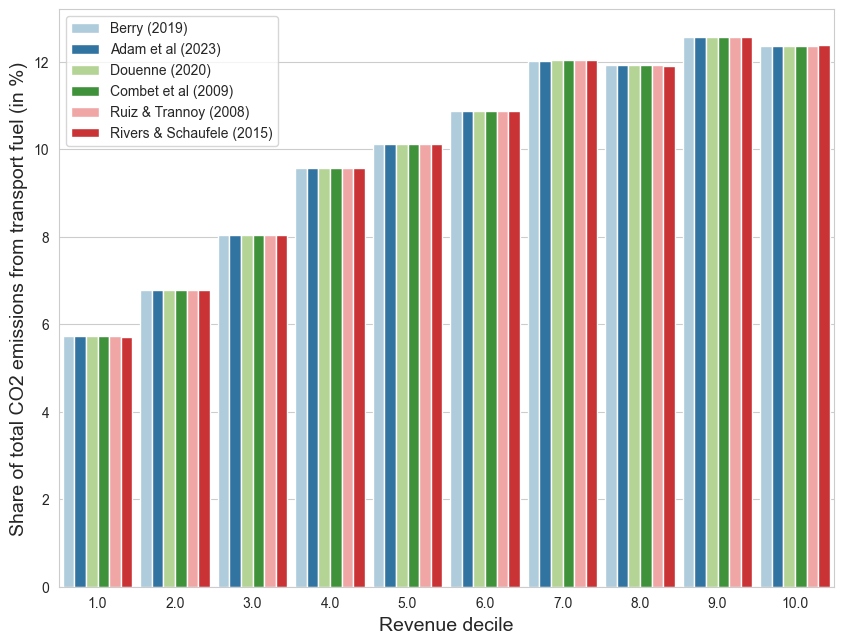

In [27]:
graph_share_co2_emissions(df_sum,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

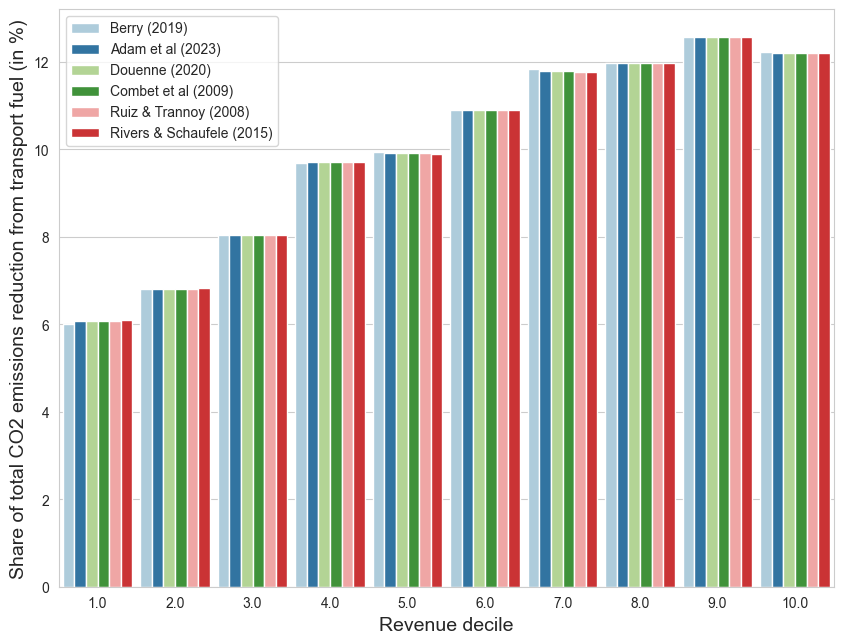

In [26]:
graph_share_emissions_reduction(df_sum,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

Text(0, 0.5, 'Emissions from transport fuel (in tCO2)')

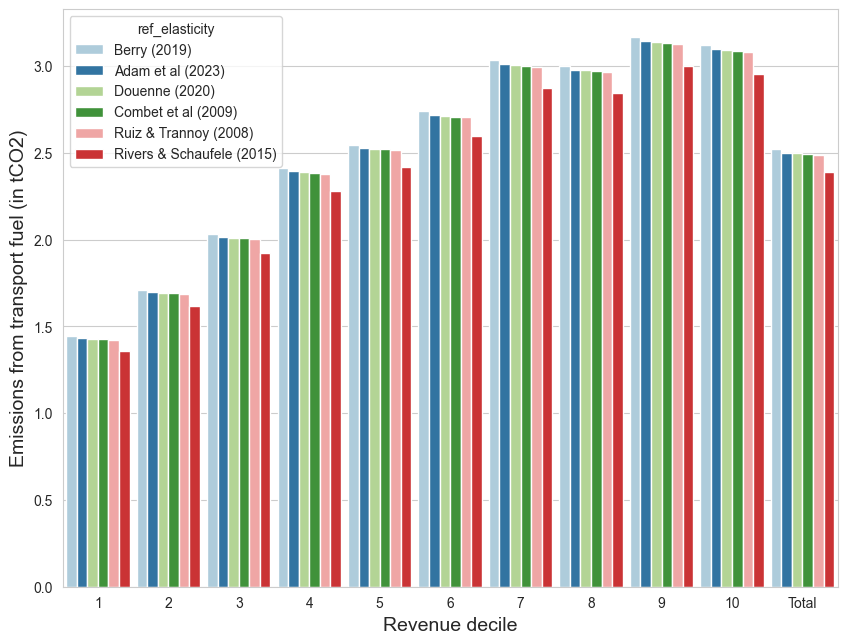

In [37]:
hue_order = ['Berry (2019)', 'Adam et al (2023)', 'Douenne (2020)', 'Combet et al (2009)', 'Ruiz & Trannoy (2008)','Rivers & Schaufele (2015)']
fig, ax = plt.subplots(figsize=(10, 7.5)) 
sns.barplot(x="niveau_vie_decile", y = 'emissions_CO2_carburants_carbon_tax_rv', data = to_graph, hue = 'ref_elasticity', hue_order = hue_order , palette = sns.color_palette("Paired"), width = .9)
plt.xlabel('Revenue decile', fontdict = {'fontsize' : 14})
plt.ylabel('Emissions from transport fuel (in tCO2)', fontdict = {'fontsize' : 14})

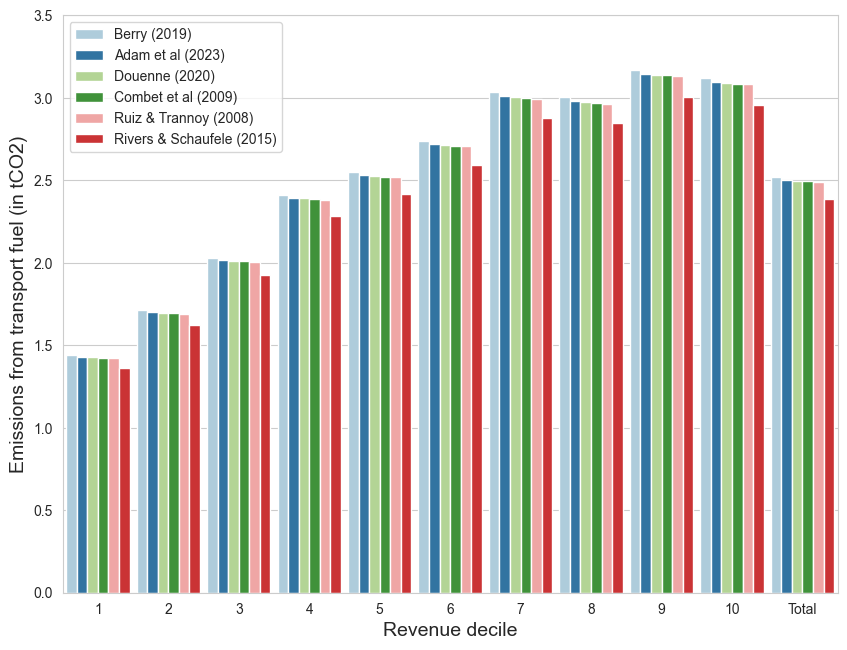

In [35]:
graph_CO2_emissions(to_graph,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

In [14]:
df_sum_douenne_only

,niveau_vie_decile,bonus_cheques_energie_uc,bonus_cheques_energie_menage,contributions_reforme,emissions_CO2_carburants,emissions_CO2_carburants_carbon_tax_rv,ticpe_totale,ticpe_totale_carbon_tax_rv,rev_disponible,pondmen,ocde10,Share_emissions_CO2,Reduction_CO2,Share_reduction_CO2,ref_elasticity,ratio_reduction_emissions
0,1.0,9.227414e+07,9.389939e+07,5.324462e+07,4.156891e+09,4.070365e+09,1.033826e+09,1.087071e+09,5.135520e+10,9.252721e+09,4.305943e+06,5.704615,-8.652506e+07,7.282418,Douenne (2020) vector,1.276584
1,2.0,9.422038e+07,9.379036e+07,6.024047e+07,4.924386e+09,4.829416e+09,1.257580e+09,1.317821e+09,8.016112e+10,8.509993e+09,4.396763e+06,6.768424,-9.497006e+07,7.993195,Douenne (2020) vector,1.180954
2,3.0,9.151169e+07,9.372188e+07,7.178586e+07,5.838052e+09,5.728267e+09,1.493447e+09,1.565233e+09,9.403654e+10,8.453708e+09,4.270363e+06,8.028164,-1.097848e+08,9.240087,Douenne (2020) vector,1.150959
3,4.0,9.284236e+07,9.385776e+07,8.732861e+07,6.946315e+09,6.816822e+09,1.765892e+09,1.853221e+09,1.099699e+11,8.523110e+09,4.332459e+06,9.553773,-1.294928e+08,10.898817,Douenne (2020) vector,1.140787
4,5.0,9.208850e+07,9.380103e+07,8.977964e+07,7.332838e+09,7.203217e+09,1.893551e+09,1.983331e+09,1.226038e+11,8.340580e+09,4.297280e+06,10.095306,-1.296209e+08,10.909601,Douenne (2020) vector,1.080661
5,6.0,9.328152e+07,9.384039e+07,1.009613e+08,7.888724e+09,7.754244e+09,2.015775e+09,2.116737e+09,1.385217e+11,8.214941e+09,4.352951e+06,10.867569,-1.344805e+08,11.318610,Douenne (2020) vector,1.041503
6,7.0,9.552364e+07,9.374837e+07,1.098720e+08,8.722184e+09,8.579917e+09,2.252802e+09,2.362674e+09,1.582898e+11,8.586329e+09,4.457580e+06,12.024750,-1.422668e+08,11.973942,Douenne (2020) vector,0.995775
7,8.0,9.545959e+07,9.381006e+07,1.144500e+08,8.643667e+09,8.509345e+09,2.206250e+09,2.320700e+09,1.799293e+11,8.519120e+09,4.454591e+06,11.925843,-1.343220e+08,11.305272,Douenne (2020) vector,0.947964
8,9.0,9.576845e+07,9.377969e+07,1.234174e+08,9.119269e+09,8.990691e+09,2.333038e+09,2.456456e+09,2.136463e+11,8.090383e+09,4.469003e+06,12.600449,-1.285786e+08,10.821871,Douenne (2020) vector,0.858848
9,10.0,9.499069e+07,9.371209e+07,1.268810e+08,8.967956e+09,8.869861e+09,2.308141e+09,2.435022e+09,3.248369e+11,7.967704e+09,4.432710e+06,12.431106,-9.809475e+07,8.256187,Douenne (2020) vector,0.664155


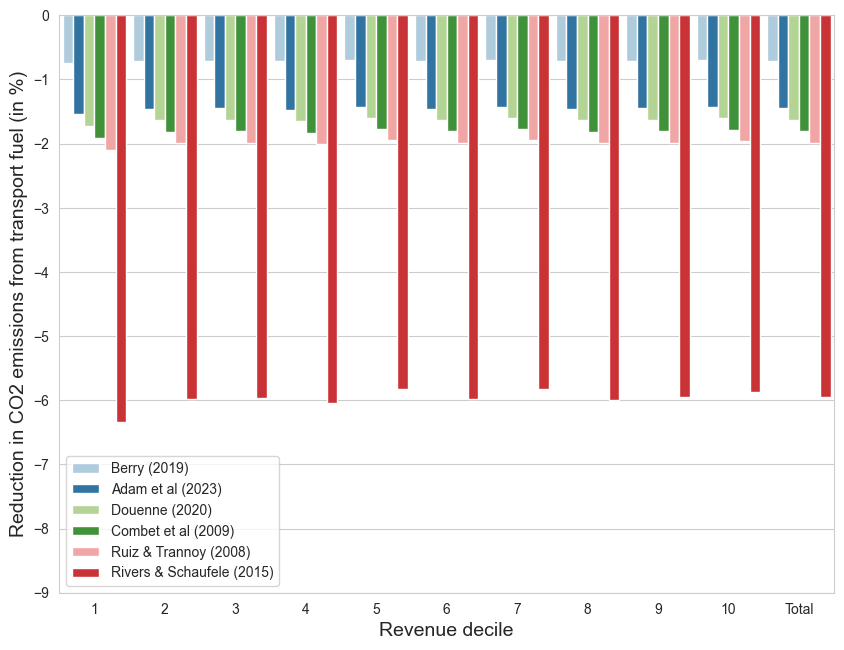

In [10]:
graph_delta_CO2(to_graph,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

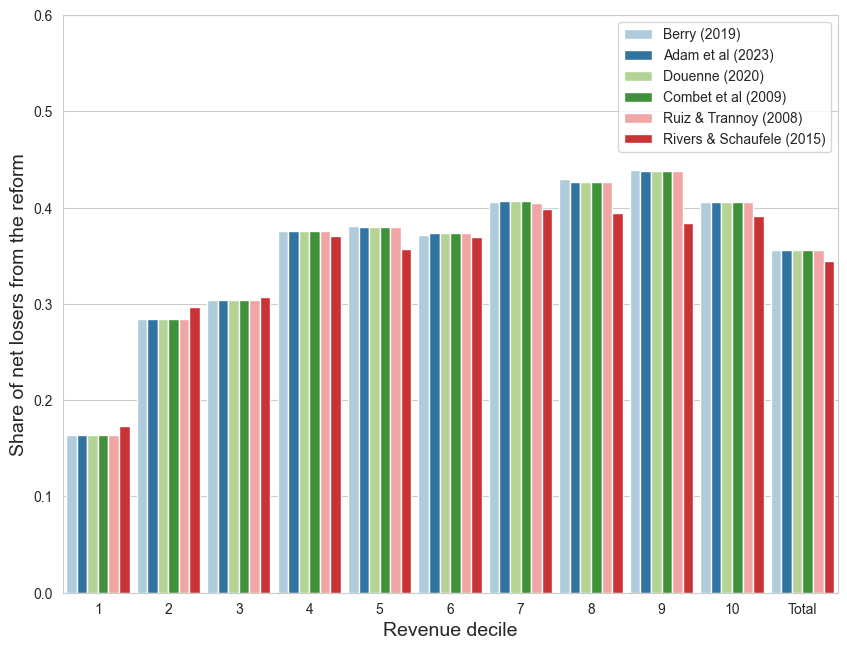

In [5]:
graph_winners_losers(to_graph,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Graph_utils.py:132: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot , x='plot_decile', y='Net_transfers_reform', hue = 'ref_elasticity',


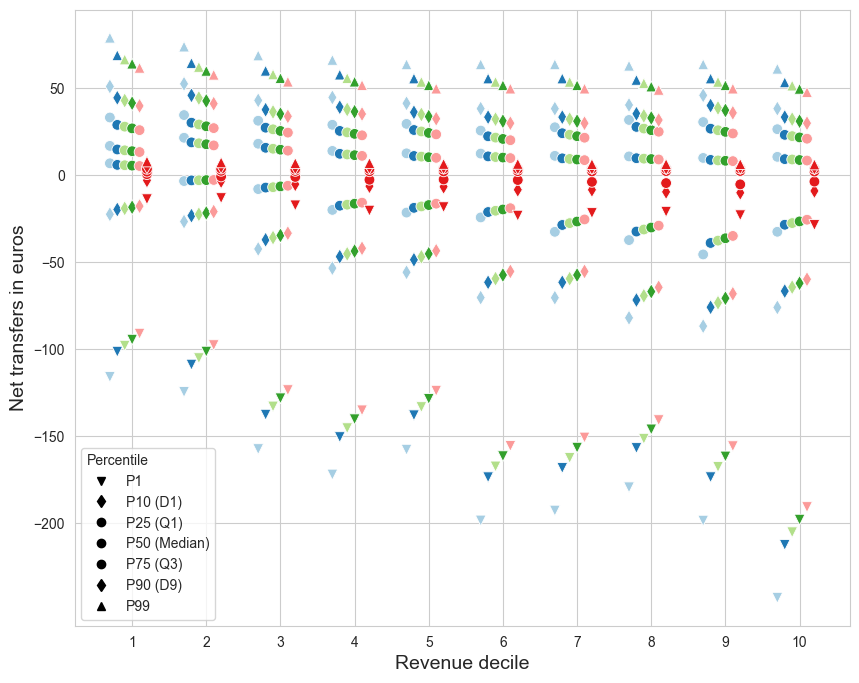

In [4]:
boxplot_net_transfers(menages_reform,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=True)

In [ ]:
quantile_net_transfers = quantiles_for_boxplot(menages_reform,'Net_transfers_reform')
quantile_net_transfers[quantile_net_transfers['quantile'] == 0.25].sort_values(by='niveau_vie_decile')

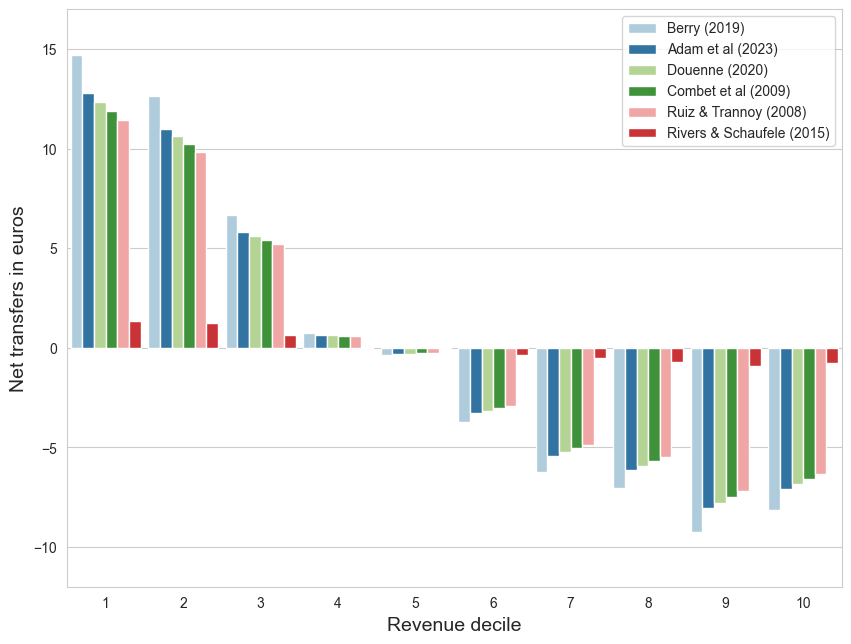

In [8]:
graph_net_transfers(to_graph,carbon_tax_rv,elas_vect = False,bonus_cheques_uc=True)

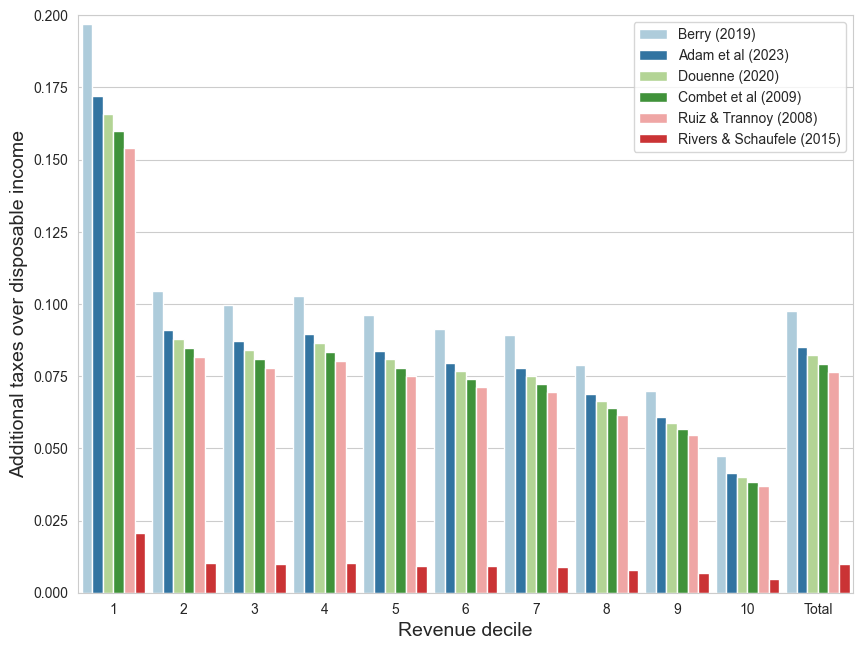

In [4]:
graph_effort_rate(to_graph,carbon_tax_rv,elas_vect = False,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Graph_utils.py:160: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot, x='plot_decile', y='Effort_rate', hue = 'ref_elasticity',


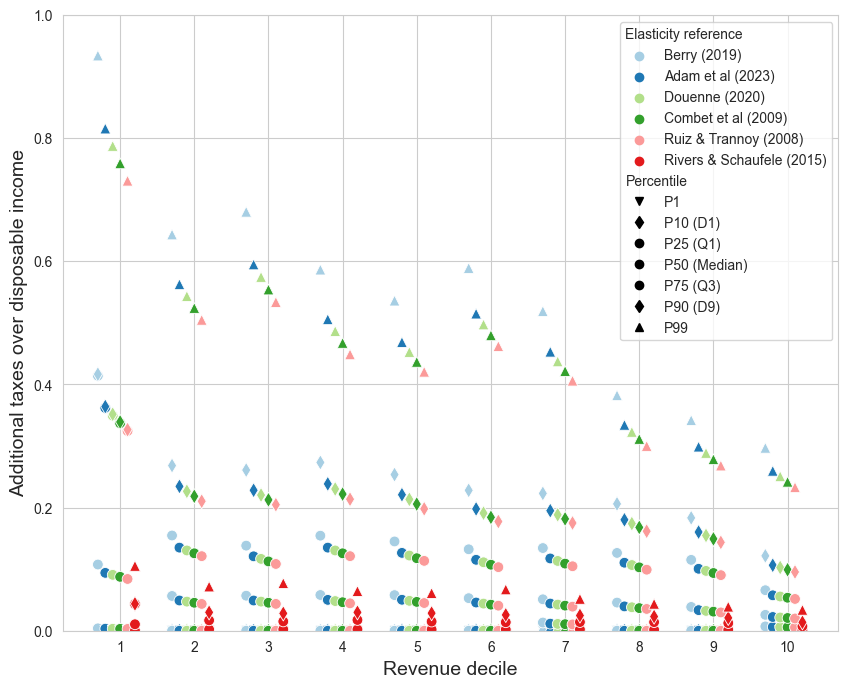

In [4]:
boxplot_effort_rate(menages_reform,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=True)

In [ ]:
quantile_effort_rate = quantiles_for_boxplot(menages_reform,'Effort_rate')
quantile_effort_rate[quantile_effort_rate['quantile'] == 0.75].sort_values(by='niveau_vie_decile')

In [4]:
df_elas_vect = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_Douenne_20.csv'), index_col = [0])
df_elas_vect = pd.melt(frame = df_elas_vect , id_vars = ["niveau_vie_decile",'ref_elasticity'], var_name = 'strate_2', value_name = 'elas_price_1_1')

In [5]:
to_graph_douenne_scal, menages_reform_douenne_scal, df_sum_douenne_scal = simulate_reformes_energie(elas_vect = True, elasticites = df_elas_vect, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_vect, menages_reform_douenne_vect, df_sum_douenne_vect = simulate_reformes_energie(elas_vect = False, elasticites = elasticites_douenne, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_only = pd.concat([to_graph_douenne_scal, to_graph_douenne_vect])
menages_reform_douenne_only = pd.concat([menages_reform_douenne_scal, menages_reform_douenne_vect])
df_sum_douenne_only = pd.concat([df_sum_douenne_scal,df_sum_douenne_vect])

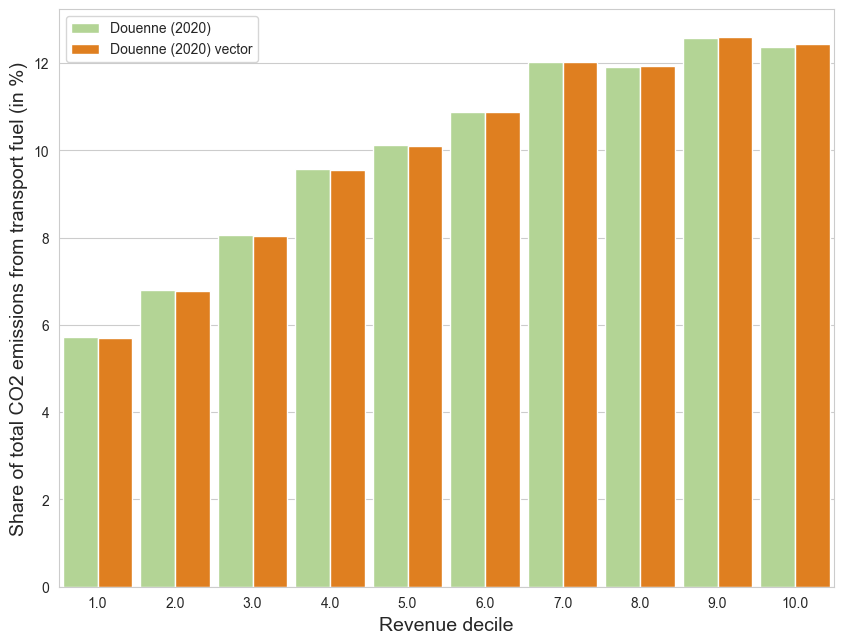

In [6]:
graph_share_co2_emissions(df_sum_douenne_only,carbon_tax_rv,elas_vect= True,bonus_cheques_uc=True)

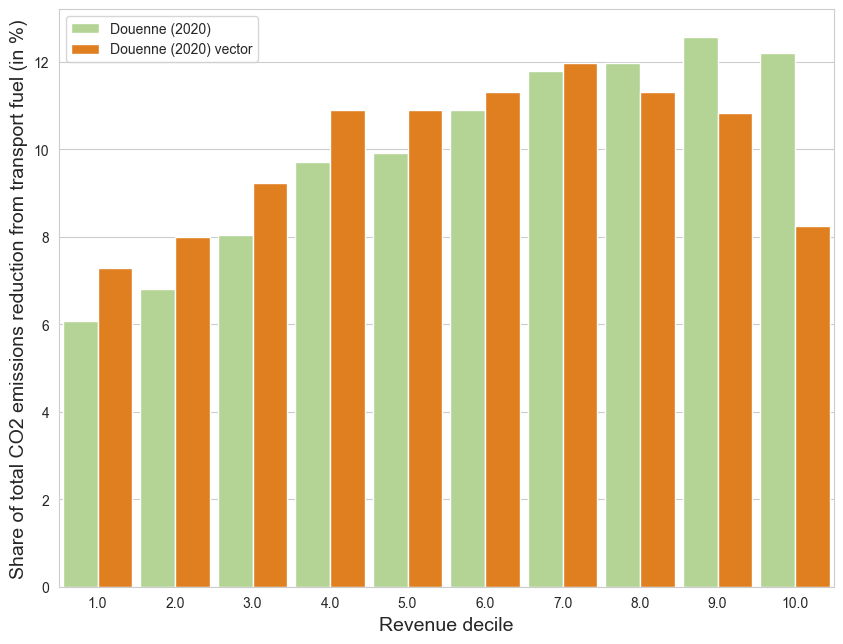

In [7]:
graph_share_emissions_reduction(df_sum_douenne_only,carbon_tax_rv,elas_vect= True,bonus_cheques_uc=True)

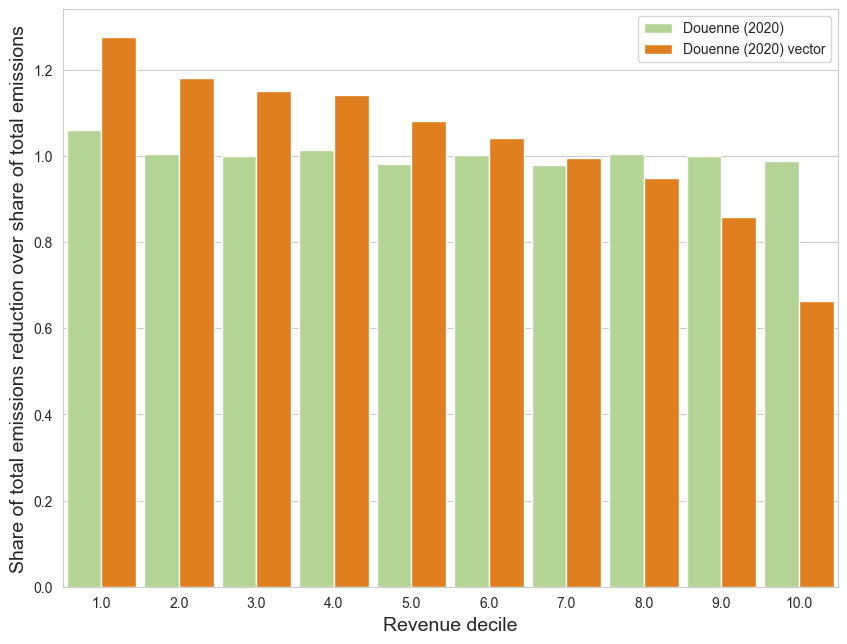

In [8]:
graph_ratio_emissions_reduction(df_sum_douenne_only,carbon_tax_rv,elas_vect= True,bonus_cheques_uc=True)

In [33]:
df_sum_douenne_only['ratio_reduction_emissions'] = df_sum_douenne_only['Share_reduction_CO2']/df_sum_douenne_only['Share_emissions_CO2']

<Axes: xlabel='niveau_vie_decile', ylabel='ratio_reduction_emissions'>

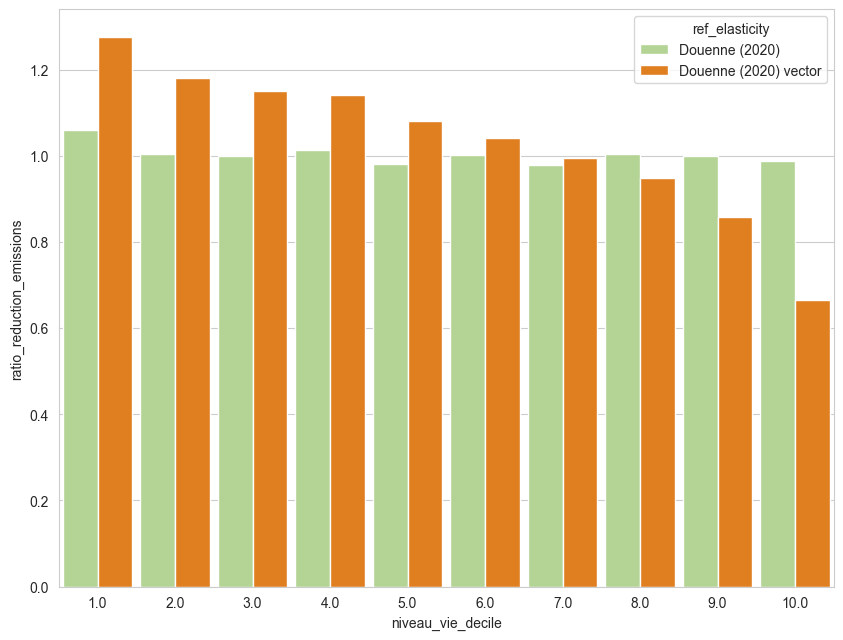

In [34]:
palette_douenne_vect = sns.color_palette([(0.6980392156862745, 0.8745098039215686, 0.5411764705882353), (1.0, 0.4980392156862745, 0.0)])
fig, ax = plt.subplots(figsize=(10, 7.5)) 
sns.barplot(x="niveau_vie_decile", y = 'ratio_reduction_emissions', data = df_sum_douenne_only, hue = 'ref_elasticity', hue_order = ['Douenne (2020)' , 'Douenne (2020) vector'], palette = palette_douenne_vect, width = .9)

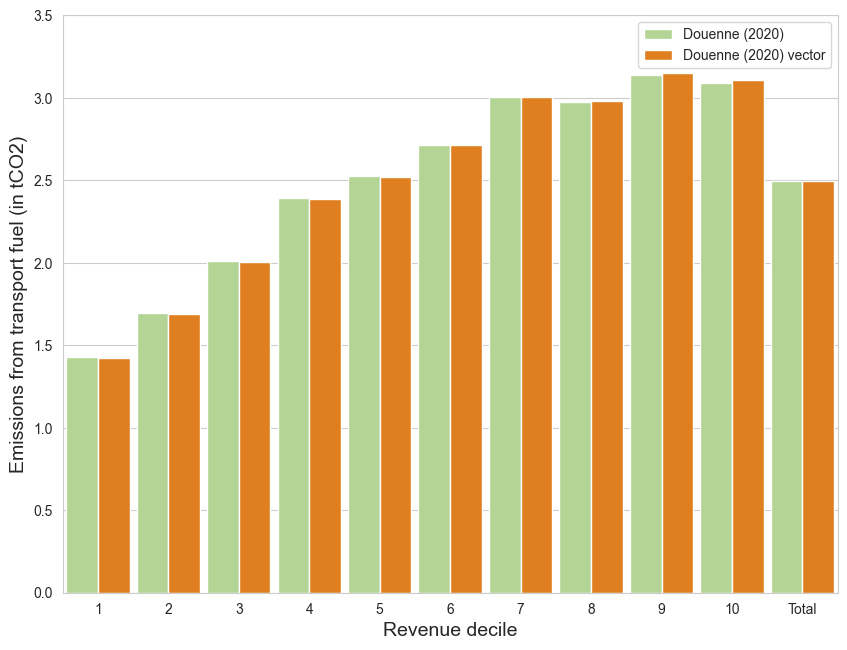

In [10]:
graph_CO2_emissions(to_graph_douenne_only,carbon_tax_rv,elas_vect= True,bonus_cheques_uc=True)

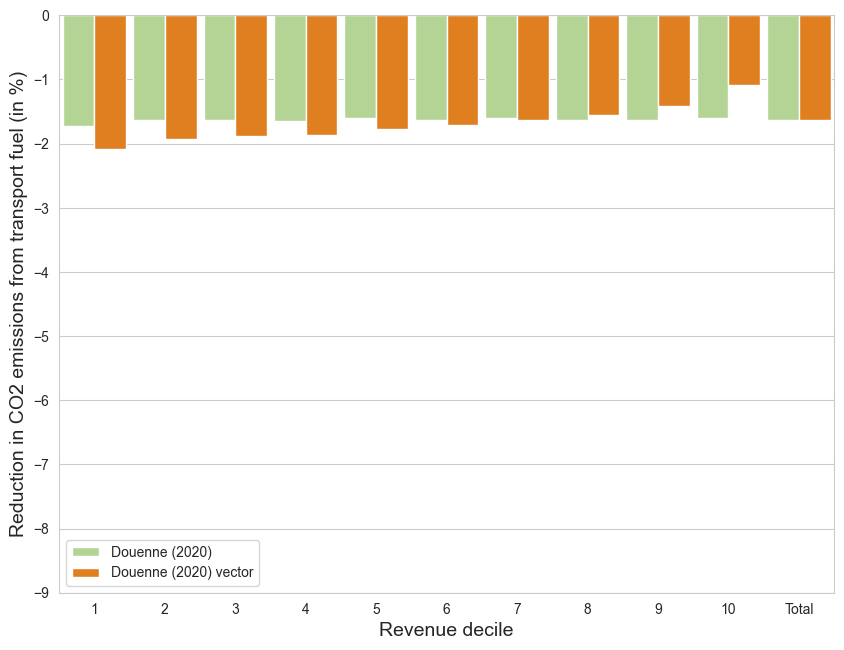

In [11]:
graph_delta_CO2(to_graph_douenne_only,carbon_tax_rv,elas_vect= True,bonus_cheques_uc=True)

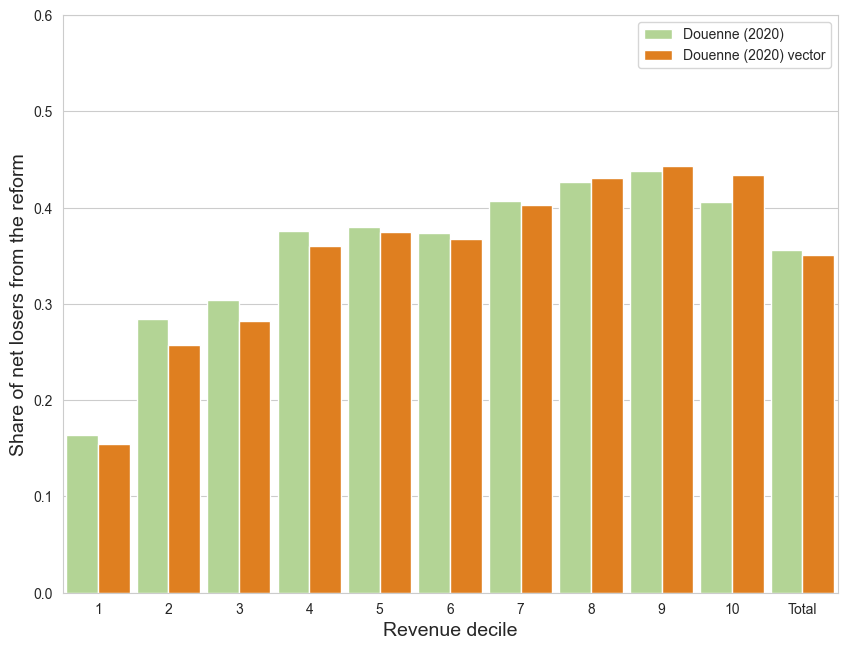

In [12]:
graph_winners_losers(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

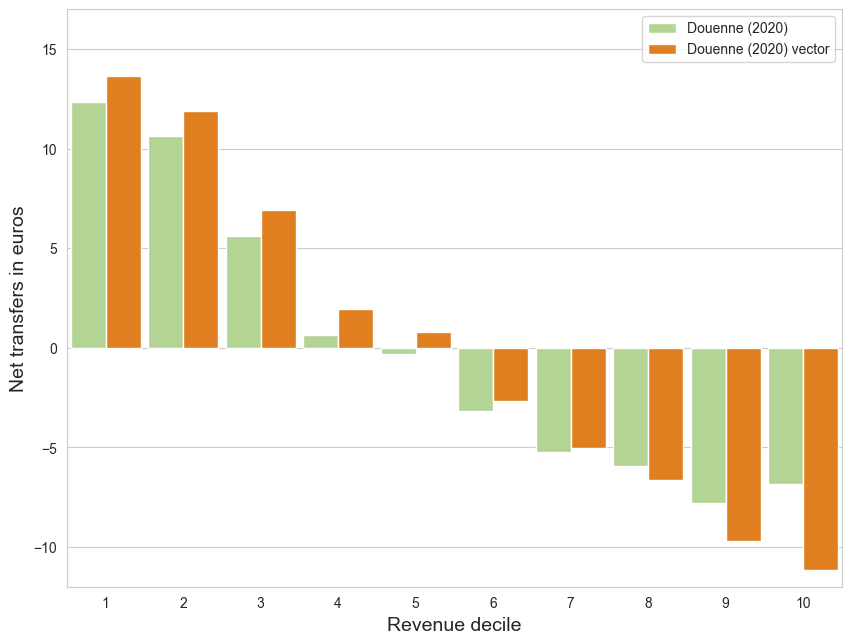

In [13]:
graph_net_transfers(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Graph_utils.py:199: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot , x='plot_decile', y='Net_transfers_reform', hue = 'ref_elasticity',


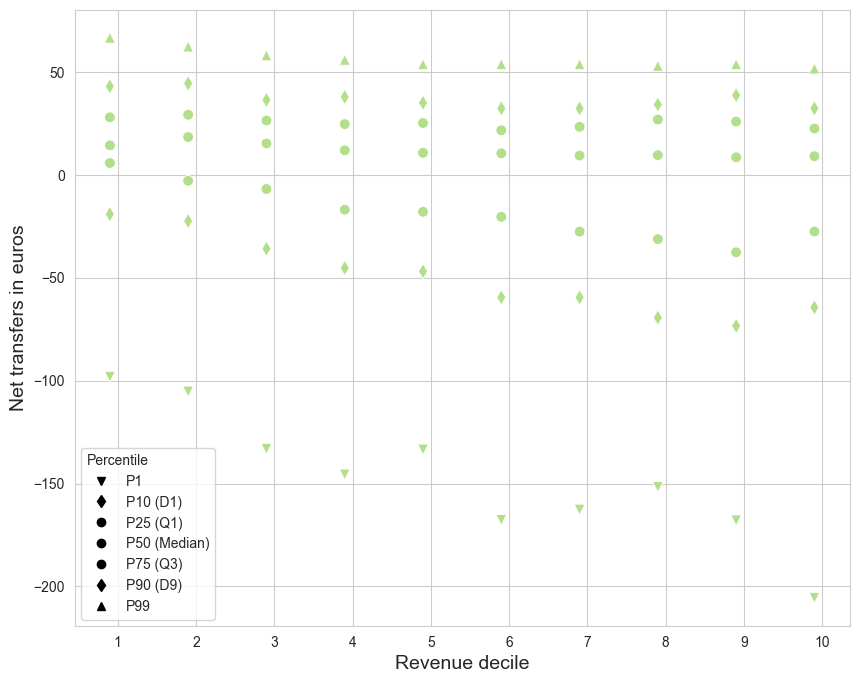

In [14]:
boxplot_net_transfers(menages_reform_douenne_only, carbon_tax_rv, elas_vect=True, bonus_cheques_uc=True)

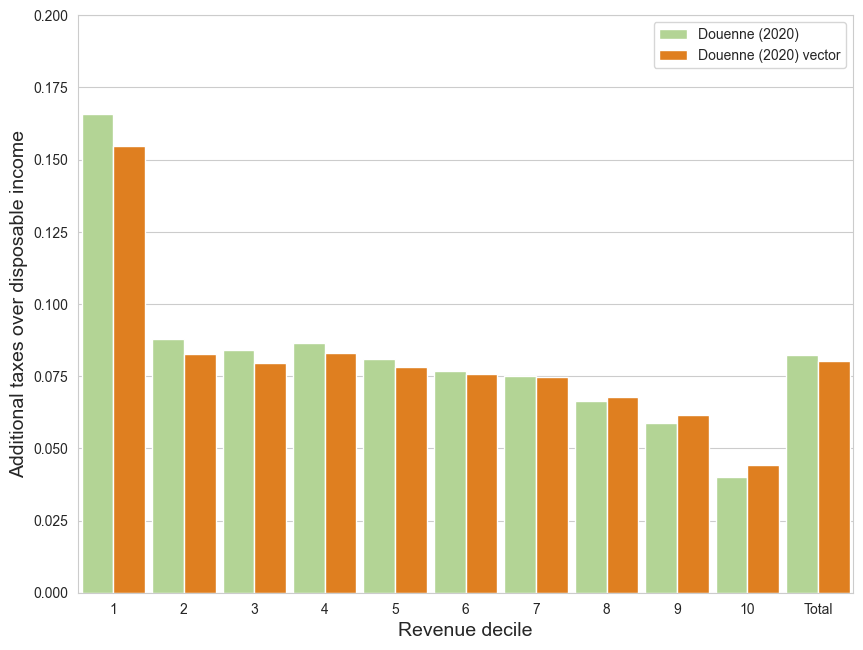

In [15]:
graph_effort_rate(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Graph_utils.py:227: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot, x='plot_decile', y='Effort_rate', hue = 'ref_elasticity',


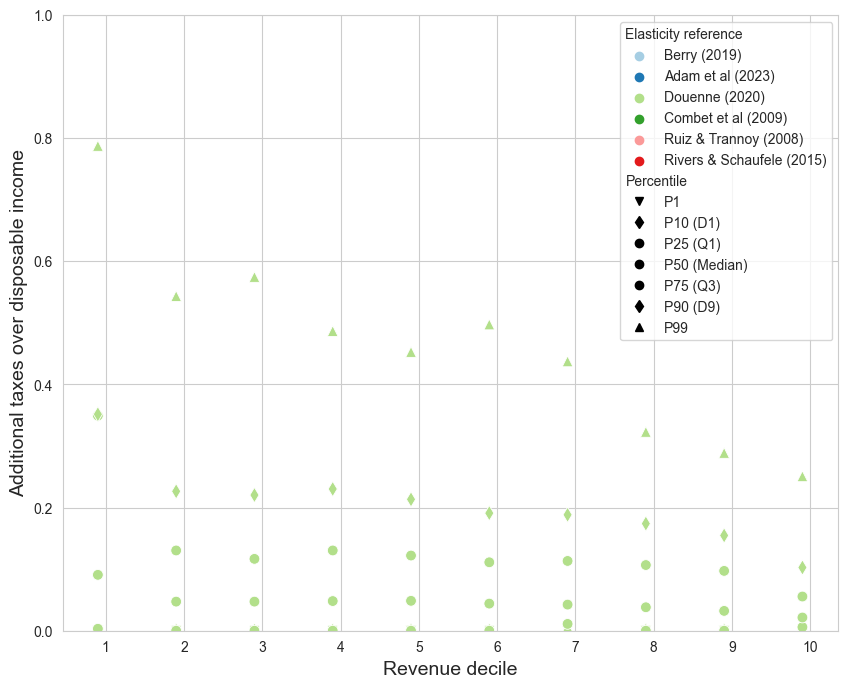

In [16]:
boxplot_effort_rate(menages_reform_douenne_only, carbon_tax_rv, elas_vect=True, bonus_cheques_uc=True)

In [17]:
to_graph_menage, menages_reform_menage = run_all_elasticities(data_elasticities = df_elasticities, year = 2019, reform = carbon_tax_rv, bonus_cheques_uc= False)

ValueError: too many values to unpack (expected 2)

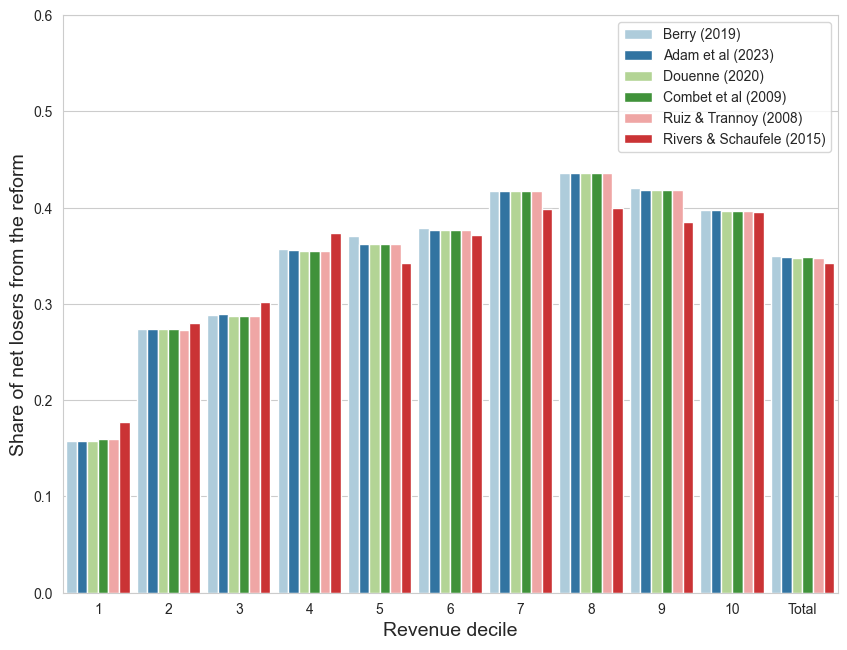

In [ ]:
graph_winners_losers(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

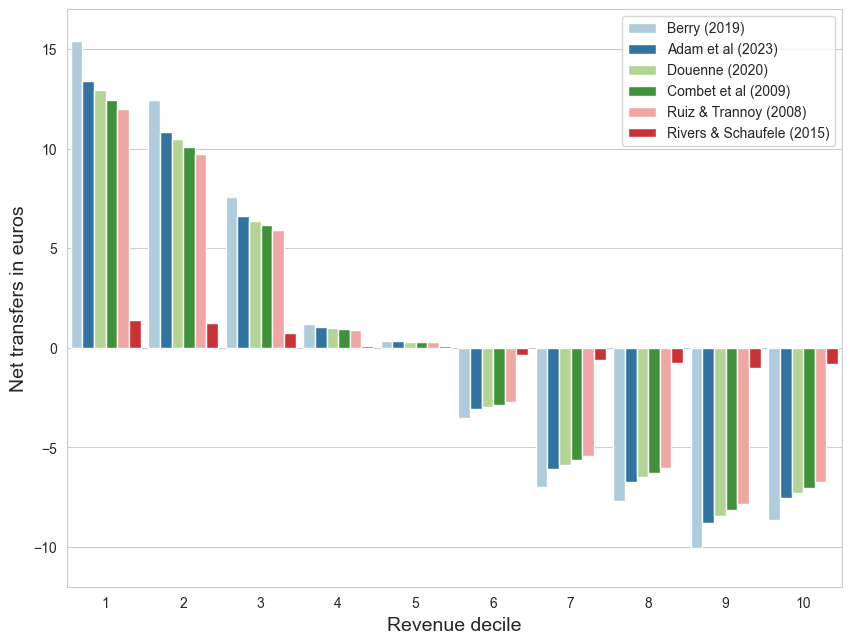

In [ ]:
graph_net_transfers(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

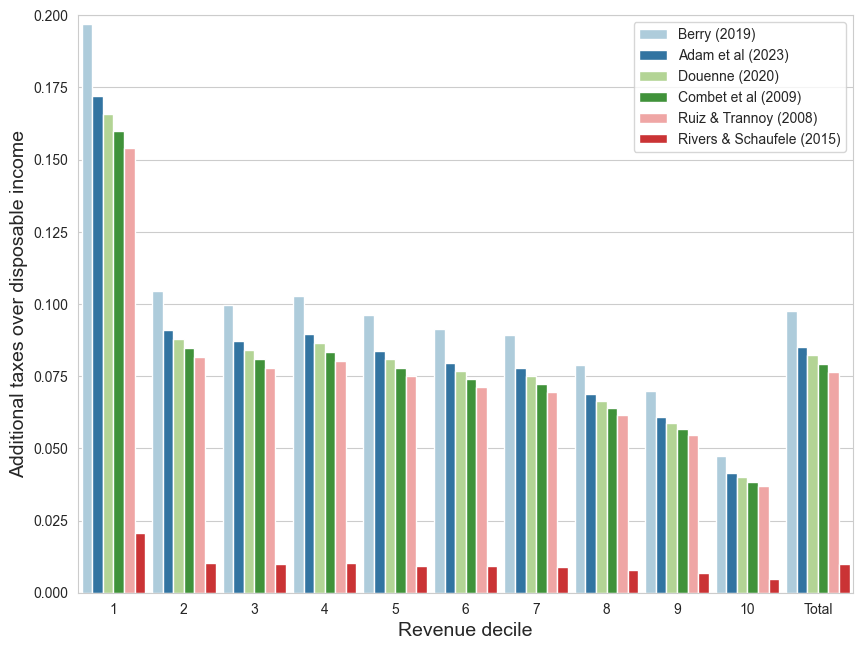

In [ ]:
graph_effort_rate(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

## A creuser !

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

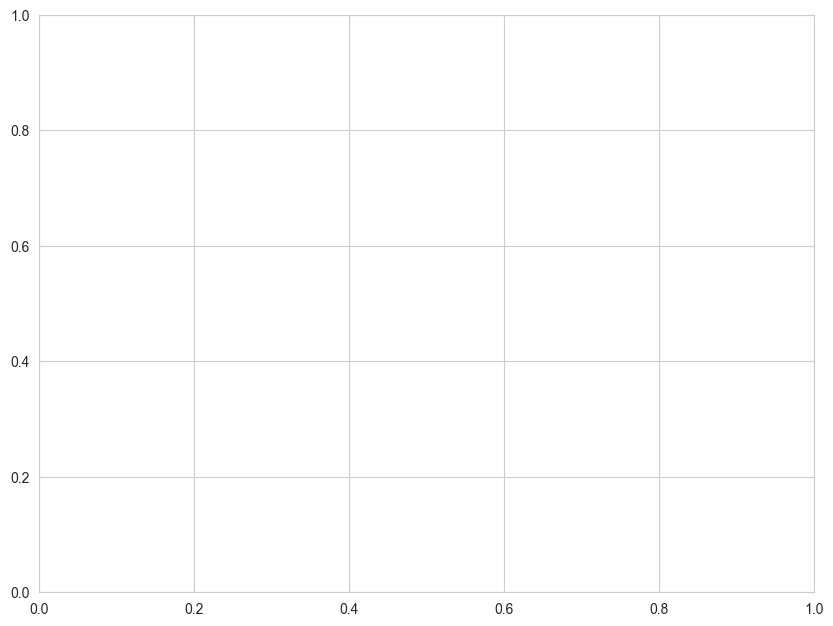

In [ ]:
boxplot_net_transfers(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\veve1\OneDrive\Documents\ENSAE 3A\Memoire MiE\hervenv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\veve1\AppData\Local\Temp\ipykernel_19344\3670938973.py", line 1, in <module>
    boxplot_effort_rate(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)
  File "c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py", line 223, in boxplot_effort_rate
  File "c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py", line 196, in quantiles_for_boxplot
    for q in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]:
  File "c:\Users\veve1\OneDrive\D

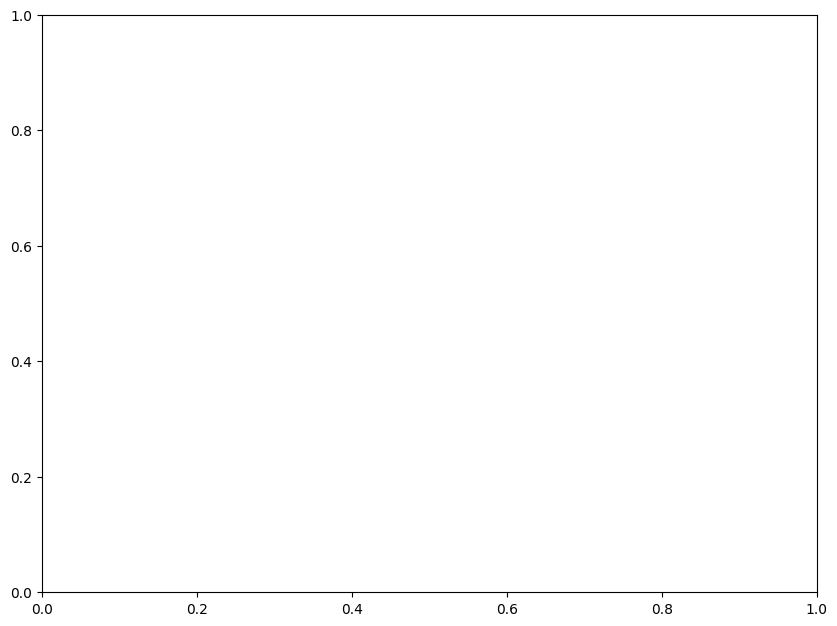

In [ ]:
boxplot_effort_rate(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)